In [1]:
import io
import os
import platform
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

In [2]:
data=pd.read_csv('toronto.csv')
data.replace(9999,np.nan,inplace=True)
data.replace(-999,np.nan,inplace=True)
for i in range(len(data)):
    for j in range(len(data.columns)):
        if np.isnan(data.iat[i,j]):
            if i==0:
                data.iloc[i,j]=data.iat[i+1,j]
            elif i==len(data)-1:
                data.iloc[i,j]=data.iat[i-1,j]
            else:
                data.iloc[i,j]=np.nanmean([data.iat[i-1,j],data.iat[i+1,j]])

In [3]:
# data.fillna(np.mean(data),inplace=True)

In [4]:
data.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Wind Chill,NO,NO2,NOx,O3,PM25
0,-6.2,-13.2,58.0,25.0,43.0,16.1,100.68,-16.0,3.0,15.0,18.0,19.0,6.0
1,-6.0,-13.7,55.0,24.0,41.0,16.1,100.59,-16.0,2.0,14.0,16.0,19.0,7.0
2,-6.2,-13.3,57.0,24.0,45.0,16.1,100.56,-16.0,1.0,10.0,11.0,22.0,7.0
3,-6.0,-12.0,63.0,24.0,32.0,16.1,100.58,-15.0,1.0,10.0,11.0,21.0,7.0
4,-6.0,-12.2,62.0,24.0,35.0,16.1,100.50,-15.0,2.0,11.0,13.0,19.0,7.0


In [5]:
dataset=pd.DataFrame(data,columns=data.columns[:])

In [6]:
scaler = preprocessing.MinMaxScaler() 
scaled_values = scaler.fit_transform(dataset) 
# dataset.loc[:,:] = scaled_values

In [7]:
data.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Wind Chill,NO,NO2,NOx,O3,PM25
0,-6.2,-13.2,58.0,25.0,43.0,16.1,100.68,-16.0,3.0,15.0,18.0,19.0,6.0
1,-6.0,-13.7,55.0,24.0,41.0,16.1,100.59,-16.0,2.0,14.0,16.0,19.0,7.0
2,-6.2,-13.3,57.0,24.0,45.0,16.1,100.56,-16.0,1.0,10.0,11.0,22.0,7.0
3,-6.0,-12.0,63.0,24.0,32.0,16.1,100.58,-15.0,1.0,10.0,11.0,21.0,7.0
4,-6.0,-12.2,62.0,24.0,35.0,16.1,100.50,-15.0,2.0,11.0,13.0,19.0,7.0


In [8]:
data_set=np.asarray(dataset,dtype=np.float32)
seq_len=30 + 1
x=len(data_set)-seq_len
sequences = [data_set[t:t+seq_len] for t in range(x)]
for i in range(len(sequences)):
    sequences[i]=scaler.fit_transform(sequences[i])

In [9]:
len(sequences)

8729

In [10]:
seq=torch.FloatTensor(sequences)

In [11]:
seq.shape

torch.Size([8729, 31, 13])

In [12]:
split_row=round(0.90*seq.size(0))
x_train_set=seq[:split_row, :-1]
y_train_set=seq[:split_row, -1]
x_valid_set=seq[split_row:, :-1]
y_valid_set=seq[split_row:, -1]

In [13]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=2,dropout=0,bidirectional=False):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.dropout=dropout
        self.bidirectional=bidirectional
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self,inputs,hidden):
        outputs,hidden=self.lstm(inputs,hidden)
        predictions=self.linear(outputs[-1])
        return predictions,outputs,hidden
    
    def init_hidden(self,batch_size):
        num_directions=2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        return hidden

In [14]:
def get_batch(x,y,i,batch_size):
    if x.dim() == 2:
        x = x.unsqueeze(2)
    batch_x = x[(i*batch_size):(i*batch_size)+batch_size, :, :]
    batch_y = y[(i*batch_size):(i*batch_size)+batch_size]

    # Reshape Tensors into (seq_len, batch_size, input_size) format for the LSTM.
    batch_x = batch_x.transpose(0, 1)
    
    return batch_x, batch_y

In [15]:
def train(model,x_train_set,y_train_set,optimizer,batch_size,epoch):
    num_sequences=x_train_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.train()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_train_set, y_train_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data
        
    print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))
    return total_loss/num_batches

In [16]:
def eval(model,x_valid_set,y_valid_set,optimizer,batch_size):
    num_sequences=x_valid_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.eval()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_valid_set, y_valid_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data

    print("Validation: Loss = {:.8f}".format(total_loss/num_batches))
    return total_loss/num_batches

In [17]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'toronto.pt'
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

In [18]:
def load_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # load the model parameters 
    model.load_state_dict(torch.load(filename))
    
    
    return model

Training model for 30 epoch
Epoch 1: Loss = 0.09509060
Validation: Loss = 0.05918957
Epoch 2: Loss = 0.05097988
Validation: Loss = 0.04321430
Epoch 3: Loss = 0.03889121
Validation: Loss = 0.03504897
Epoch 4: Loss = 0.03305316
Validation: Loss = 0.03137194
Epoch 5: Loss = 0.03051212
Validation: Loss = 0.02984560
Epoch 6: Loss = 0.02913393
Validation: Loss = 0.02903615
Epoch 7: Loss = 0.02813826
Validation: Loss = 0.02849719
Epoch 8: Loss = 0.02742096
Validation: Loss = 0.02807740
Epoch 9: Loss = 0.02692456
Validation: Loss = 0.02775497
Epoch 10: Loss = 0.02655434
Validation: Loss = 0.02751390
Epoch 11: Loss = 0.02625710
Validation: Loss = 0.02732726
Epoch 12: Loss = 0.02601390
Validation: Loss = 0.02717685
Epoch 13: Loss = 0.02581427
Validation: Loss = 0.02704862
Epoch 14: Loss = 0.02564753
Validation: Loss = 0.02693273
Epoch 15: Loss = 0.02550608
Validation: Loss = 0.02682603
Epoch 16: Loss = 0.02538272
Validation: Loss = 0.02672643
Epoch 17: Loss = 0.02527282
Validation: Loss = 0.0266

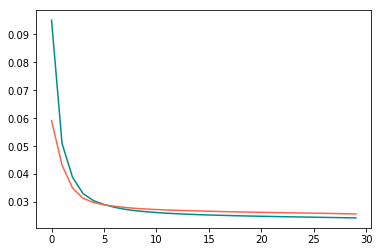

In [19]:
input_size=13
hidden_size=24
num_layers=2
lstm=LSTM(input_size,hidden_size)

learning_rate=0.001
max_grad_norm=5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=0.00001)

batch_size = 8
num_epochs = 30 #3
# num_sequences = x_train_set.size(0)
# num_batches = num_sequences //batch_size

checkpoint_freq = 10
path = './'

train_losses=[]
valid_losses=[]

print("Training model for {} epoch".format(num_epochs))
for epoch in range(num_epochs):
#     total_loss = 0

    # Shuffle input and target sequences.
    idx = torch.randperm(x_train_set.size(0))
    x = x_train_set[idx]
    y = y_train_set[idx]
    
    train_loss=train(lstm,x_train_set,y_train_set,optimizer,batch_size,epoch)
    valid_loss=eval(lstm,x_valid_set,y_valid_set,optimizer,batch_size)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, lstm, path)
        
# Last checkpoint
save_model(num_epochs, lstm, path)
    
print("\n\n\nOptimization ended.\n")

plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(valid_losses, color="tomato",label="validation")
plt.show()

In [20]:
def predict_one_hour(model,x_valid_set,input_size,num_steps):
    predictions=torch.zeros(num_steps)
    for i, x in enumerate(x_valid_set):
        hidden=model.init_hidden(1)
        y_pred,_,_=model(x.contiguous().view(-1, 1, input_size),hidden)
        predictions[i]=y_pred[:,-1]
    return predictions

In [21]:
one_step_predictions = predict_one_hour(lstm, x_valid_set, input_size, y_valid_set.size(0))

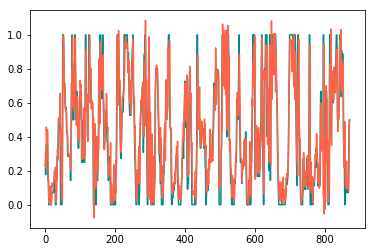

In [22]:
plt.plot(y_valid_set[:,-1].data.numpy(),color='darkcyan')
plt.plot(one_step_predictions.data.numpy(),color='tomato')
plt.show()